In [4]:
#Define the BaseLocalPlanner object
class BaseLocalPlanner{ #Change to class
    public:
        bool computeVelocityCommands(cmd_vels::Vector{Float64}); #This will be the twist object
        void initialize(name::String, transfromPointer, costmap); # The second variable is a tf::TransfomListener*, costmap_2d::Costmap2DROS*
        bool isGoalReached();
        bool setPlan(path) #input is a constant vector of PoseStamped objects - gives times and positions
        ~BaseLocalPlanner();
    private:
        BaseLocalPlanner();        
}

LoadError: LoadError: syntax: missing comma or } in argument list
while loading In[4], in expression starting on line 5

In [ ]:
#Function polyPathLocal creates a nth order polynomial to be fit and optimized between the current copter configuration
# and a configuration on the global plan.
#Assumptions
# Default global path to plan to is Dijkstras
#Inputs
# Odometry.msg containing
#  current_Position - the current position of the robot, an object with x, y, and z points
#  current_Quaternion - the current orientation of the robot based on quaternions
#  current_Velocity - a vector of current velocities of the robot
#  current_YawRate - a value of yaw rate
# Path.msg either containing or providing
#  desired_Positions - an array of positions x,y,z, yaw = p
#  desired_Velocities - the end velocities for x,y,z,p
#  desired_Acceleration - the end accelerations for x,y,z,p
# flagFMT - a boolean that is true to indicate a computation assuming FMT global plan
# costMap - an array of cost values from 0-255
#Outputs
# Path.msg containing
#  path - an array of positions
#  timeStamps - an array of times corresponding to each position in the path
#  



In [ ]:
#Function computeVelocityCommands will compute the velocity commands to send to the base given current position, orientation
# and velocity
#Inputs
# 
#Outputs
# 
function computeVelocityCommands(cmd_vels::Vector{Float64})
    
    
end

In [ ]:
#Function initialize constructs the local planner
#Inputs
# name - the name to give this instance of the local planner
# tf - a pointer to a transform listener
# costmap_ros - the cost map to use for assignning costs to local plans
#Outputs
# Nothing
function initialize(name::String, tf, costmap)
    #Set name of the object to name
    #Set the tf
#Outputs
# 
function isGoalReached()
    
    #Read in costmap from global centered around robot
end

In [ ]:
#Function isGoalReached checks if the goals has been reached
#Inputs
# 
#Outputs
# 
function isGoalReached()
    
    
end

In [165]:
#Function setPlan sets the plan that the local planner is following
#Inputs
# 
#Outputs
# 
function setPlan(path)
    
    
end

setPlan (generic function with 1 method)

In [921]:
include("FunctionsHelper.jl")


get_grid_resolution (generic function with 1 method)

Float64, Float64, Float64, Float64) in module Main at C:\Users\tmurphy10\Documents\ShieldAi\polynomial-path-smoothing\FunctionsHelper.jl:6 overwritten at C:\Users\tmurphy10\Documents\ShieldAi\polynomial-path-smoothing\FunctionsHelper.jl:6.


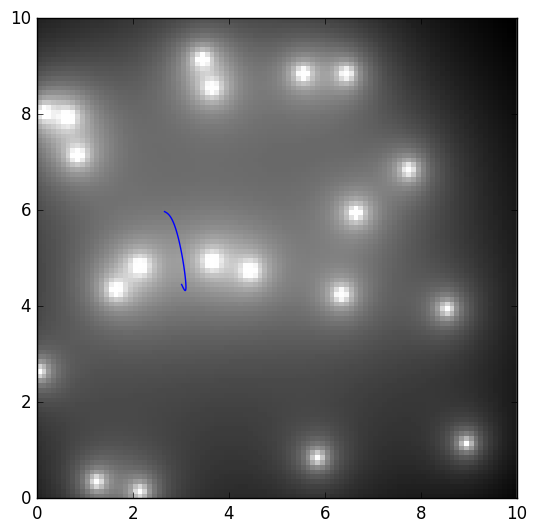

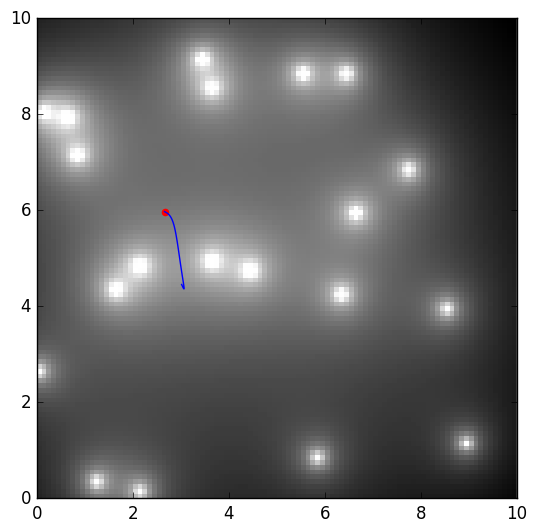

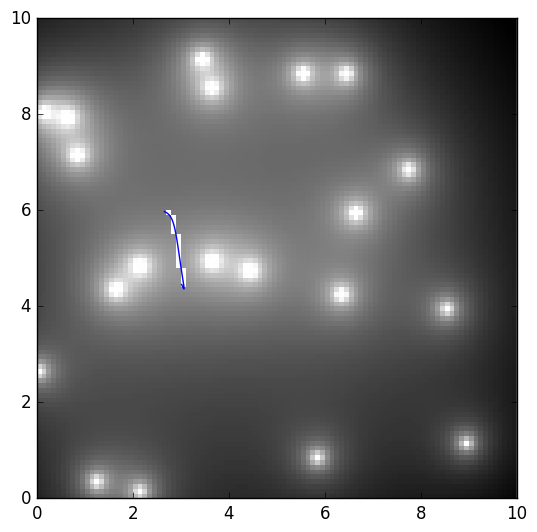

Made it through optimization according to percision
unverified
unverified
unverified
unverified
verified
Time of Path: 5.0


PyObject <matplotlib.image.AxesImage object at 0x0000000057D09BA8>

In [959]:

#Function polyPathLocal creates a 7th order polynomial to be fit and optimized between the current copter configuration
# and a configuration on the global plan.
#Assumptions
# Default global path to plan to is Dijkstras
# Average distance for local planner is 10 meters
# Three initial conditions are known
#Inputs
# current_Pos - the initial positions x,y,z, yaw = p
# current_Vel - the initial velocities in x,y,z, yaw = p
# current_Accel - the initial accelerations in x,y,z, yaw = p
# final_Pos - the final positions in x,y,z, yaw = p
# final_Vel - te final velocities in x,y,z, yaw = p
# final_Accel - the final accelerations in x,y,z, yaw = p
# costmap - an array of values from 0-255 to designate cost of traveling in a certain square by obstacles
# q_coeffs - a vector of weights to be applied to the derivative costs
# obstacleWeight - the weight applied to the obstacles in the cost function
# flag - a boolean that will decide between dijkstras or FMT global planning assumption, true -> fmt
# perturbStep - the amount of distance to start the gradient descent
# iterations - number of iterations to optimize over
#Outputs
# polyPath - the coefficients of the polynomial of the planned path
#####################Testing###########
#Create costmap
# Form a grid which shows the cells we check:
width = get_grid_extent();
res   = get_grid_resolution();
n = round(Int64,ceil(width/res));
costmap = zeros(n,n,n);
#Create a certain amount of objects
for tc = 1:20
    index1 = round(rand()*get_grid_extent()/get_grid_resolution());
    index2 = round(rand()*get_grid_extent()/get_grid_resolution());
    for l = 1:size(costmap,1)
        for p = 1:size(costmap,2)
            costmap[l,p,1] += 255/(sqrt((l-index1)^2+(p-index2)^2)+1);
            if(costmap[l,p,1]>255)
                costmap[l,p,1] = 255;
            end
        end
    end
end
        #Flip costmap for ploting purposes
        pcostmap = costmap[:,:,1];
        temp_costmap = zeros(size(pcostmap,1),size(pcostmap,2))
        for h =1:size(costmap,1)
            for g = 1:size(costmap,2)
                temp_costmap[h,g,1] = costmap[h,size(pcostmap,2)-g+1,1];
            end
        end
        temp_costmap=temp_costmap';
#Things for testing
vel_lim = 1*2;
accel_lim = 0.65/4*2;
##########################
current_Pos = Point(rand()*(get_grid_extent()-5)+2,rand()*(get_grid_extent()-5)+2,0,0);
current_Vel = Point((rand()-0.5)*vel_lim,(rand()-0.5)*vel_lim,0,0);
current_Accel = Point(0,0,0,0);
final_Pos = Point(rand()*(get_grid_extent()-5)+2,rand()*(get_grid_extent()-5)+2,0,0);
final_Vel = Point((rand()-0.5)*vel_lim,(rand()-0.5)*vel_lim,0,0);
final_Accel = Point((rand()-0.5)*accel_lim,(rand()-0.5)*accel_lim,0,0);
flag = true;
q_coeff = zeros(6+flag);
#q_coeff[2] = 1;
q_coeff[4] = 1;
obstacleWeight = 0.05;
lowerQeffs = 100000;
iterations = 100;
perturbStep = 200;
precision = 0.000001;
dim = 2;
max_vel = 2.0;
max_accel = 0.65;
max_jerk = 100.0;
max_rpm = 100000000000.0;
timeStep  = 0.005;
aggressParam = 0.7;
timeIncrease = 1;
timeStart = 1.0;#sqrt((current_Pos.x-final_Pos.x)^2 + (current_Pos.y - final_Pos.y)^2)/max_vel;
###########################################
#Changeable value
num_free = 1;
num_points = 2;

#Read in the states avaiable in the order initials, finals
if(flag)
    #All constraints
    x_constr = [current_Pos.x; current_Vel.x; current_Accel.x; final_Pos.x; final_Vel.x; final_Accel.x];
    y_constr = [current_Pos.y; current_Vel.y; current_Accel.y; final_Pos.y; final_Vel.y; final_Accel.y];
    z_constr = [current_Pos.z; current_Vel.z; current_Accel.z; final_Pos.z; final_Vel.z; final_Accel.z];
    p_constr = [current_Pos.p; current_Vel.p; current_Accel.p; final_Pos.p; final_Vel.p; final_Accel.p];
else
    #if dijkstras create a velocity approximation from the two points assuming traversed in a second - this gets relaxed
    #later in the verification step also note the lack of a final acceleration
    x_constr = [current_Pos.x; current_Vel.x; current_Accel.x; final_Pos.x; (final_Pos.x - current_Pos.x)];
    y_constr = [current_Pos.y; current_Vel.y; current_Accel.y; final_Pos.y; (final_Pos.y - current_Pos.y)];
    z_constr = [current_Pos.z; current_Vel.z; current_Accel.z; final_Pos.z; (final_Pos.z - current_Pos.z)];
    p_constr = [current_Pos.p; current_Vel.p; current_Accel.p; final_Pos.p; (final_Pos.p - current_Pos.p)];
end
#Set up the constraint matrix in the order initials, finals (plus another constraint for optimization)
num_constr = length(x_constr)+num_free;
#The two corresponds to acceleration being the 2nd derivative three 
#if dijkstras create a free variable of acceleration else create another constraint for jerk
orders = [collect(0:2); collect(0:(2+flag))];
#Create time vector assuming 1 second for the final conditions and zero for the initial conditions
#There are three zeros for three initial conditions
#The last value is flag to be a one when fmt is used otherwise it will be in the vector as a zero that is never used
times = [0.0;timeStart];
timeIndex = [0;0;0;1;1;1;flag];
#Calculate some numbers
tot_degree = num_constr;


#Set up A matrix so that Ap = d where p is the coefficients of the polynomial and d are the constraints in a vector
A = zeros(tot_degree, tot_degree);
for k=1:tot_degree
    A[k,:] = constr_order(orders[k], times[timeIndex[k]+1],tot_degree);
end
#Calculate A inverse
A_inv = inv(A);
Au = A_inv;
# Form Q matrix where cost = p'Qp without the costmap
Q = form_Q(q_coeff, times[end]-times[1]); 
#Solve for the optimal ends with no costmap first
R = A_inv'*(Q*A_inv);
#short for optimizing matrix
opt_mat = -( R[(tot_degree-num_free+1):tot_degree, (tot_degree-num_free+1):tot_degree])\R[1:(tot_degree-num_free), 
    (tot_degree-num_free+1):tot_degree]';
#Record the optimized value in a variable for later gradient descent; will only work for 1 free variable at the moment
x_free = opt_mat * x_constr;
y_free = opt_mat * y_constr;
z_free = opt_mat * z_constr;
p_free = opt_mat * p_constr;
x_coeffs = A_inv * [x_constr; x_free];
y_coeffs = A_inv * [y_constr; y_free];
z_coeffs = A_inv * [z_constr; z_free];
p_coeffs = A_inv * [p_constr; p_free];

#Plot the poly optimized only for derivative costs
figure()
plotTimes = linspace(0,times[end],100);
plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
#println([x_constr; x_free])
#println([y_constr; y_free])
#println(opt_mat * x_constr)
#Check the cost with the costmap by first finding the squares the path goes through
#Find the cells of that the polynomial passes through; the last 5 inputs here are the three grid resolutions,
# the dimension and an aggression param
cells,holder = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, timeIndex, get_grid_resolution(), 
    get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
#Check if out of bounds and avoid loop
if(holder)
    println("path went out of bounds")
    unOptimized = false;
else
    unOptimized = true;
end
#The division by three is to normalize the costs from the coefficients#
#println(cells)
cost1 = (x_coeffs' * Q * x_coeffs + y_coeffs' * Q * y_coeffs + z_coeffs' * Q * z_coeffs)/3/lowerQeffs +
    obstacleWeight*sum(costmap[cells]);
#Optimize for cost using gradient descent
counter = 0;
#Start the while loop until optimized or over the number of times to iterate
while(unOptimized && counter <= iterations)
    #println("in cost loop")
    #Perturb every dimension and solve for the new polynomials
    delta = perturbStep;
    #Check the cost of each perturbed poly, if increased, change the perturbation direction, record the rate of change
    x_coeffsP = A_inv * [x_constr; x_free+perturbStep];
    cells,holder = occupancyCellChecker(x_coeffsP, y_coeffs, z_coeffs, times, get_grid_resolution(),
        get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
    #Check if out of bounds and break out since without accurate costs things would get messed up
    if(holder)
        println("path went out of bounds")
        break;
    end
    costx = (x_coeffsP' * Q * x_coeffsP + y_coeffs' * Q * y_coeffs + z_coeffs' * Q * z_coeffs)/3/lowerQeffs +
        obstacleWeight*sum(costmap[cells]);
    rateChangex = (costx-cost1)/perturbStep;
    y_coeffsP = A_inv * [y_constr; y_free+perturbStep];
    cells, holder = occupancyCellChecker(x_coeffs, y_coeffsP, z_coeffs, times, get_grid_resolution(), 
        get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
    #Check if out of bounds and break out since without accurate costs things would get messed up
    if(holder)
        println("path went out of bounds")
        break;
    end
    costy = (x_coeffs' * Q * x_coeffs + y_coeffsP' * Q * y_coeffsP + z_coeffs' * Q * z_coeffs)/3/lowerQeffs +
        obstacleWeight*sum(costmap[cells]);
    rateChangey = (costy-cost1)/perturbStep;
    z_coeffsP = A_inv * [z_constr; z_free+perturbStep];
    cells, holder = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffsP, times, get_grid_resolution(), 
        get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
    #Check if out of bounds and break out since without accurate costs things would get messed up
    if(holder)
        println("path went out of bounds")
        break;
    end
    costz = (x_coeffs' * Q * x_coeffs + y_coeffs' * Q * y_coeffs + z_coeffsP' * Q * z_coeffsP)/3/lowerQeffs +
        obstacleWeight*sum(costmap[cells]);
    rateChangez = (costz-cost1)/perturbStep;

    #Calculate the vector direction of maximum descent
    dir = normalize!([rateChangex[1]*(-sign(rateChangex)[1]); rateChangey[1]*(-sign(rateChangey)[1]); rateChangez[1]*(-sign(rateChangez)[1])]);

    #Step in that direction for all variables
    x_free += perturbStep * -sign(rateChangex)[1]*abs(dir[1]);
    y_free += perturbStep * -sign(rateChangey)[1]*abs(dir[2]);
    z_free += perturbStep * -sign(rateChangex)[1]*abs(dir[3]);

    #Calculate poly and cost and see if actually decreased
    x_coeffs = A_inv * [x_constr; x_free];
    y_coeffs = A_inv * [y_constr; y_free];
    z_coeffs = A_inv * [z_constr; z_free];
    cells,holder = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, times, get_grid_resolution(), 
        get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
    #Check if out of bounds and break out since without accurate costs things would get messed up
    if(holder)
        println("path went out of bounds")
        break;
    end
    #The division by three is to normalize the costs from the coefficients
    costNew = (x_coeffs' * Q * x_coeffs + y_coeffs' * Q * y_coeffs + z_coeffs' * Q * z_coeffs)/3/lowerQeffs +
        obstacleWeight*sum(costmap[cells]);
    #If not decreased half the step and recompute
    if((cost1-costNew)[1] < 0)
        #println("shortened step")
        perturbStep = perturbStep/2;
        x_free -= perturbStep * -sign(rateChangex)[1]*abs(dir[1]);
        y_free -= perturbStep * -sign(rateChangey)[1]*abs(dir[2]);
        z_free -= perturbStep * -sign(rateChangex)[1]*abs(dir[3]);
    end
    #Check if within small change
    if(abs(perturbStep * dir[1]) < precision && abs(perturbStep * dir[2]) < precision && abs(perturbStep * dir[3]) < precision)
        unOptimized = false;
        println("Made it through optimization according to percision")
    end
    counter += 1;
    #println("counter: ", counter, "  iterations: ", iterations)
    #update cost
    cost1 = costNew;
    #println(cost1)
end
#end while

if(counter>iterations)
    println("Optimization ended because went through all iterations")
end
#println((x_coeffs' * Q * x_coeffs + y_coeffs' * Q * y_coeffs + z_coeffs' * Q * z_coeffs)/3/lowerQeffs )
#println(obstacleWeight*sum(costmap[cells]))

#Plot the optimized polyseg
#figure()
#plotTimes = linspace(0,times[end],100);
#plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
#imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
#Color the cells of the poly
#Check if collided by checking last cost bit
#println(costmap[cells])
#Start repeat if not verified
unverified = true;
counter2 = 0;
timeV = times[end];
sol = PolySol(num_points-1, times, x_coeffs, y_coeffs, z_coeffs, p_coeffs); 
while(unverified && !holder)
    #verfiy path is feasible based on constraints    
    errorTimes = verifyActuateablePath(sol, max_vel*timeV, max_accel*timeV^2, max_jerk*timeV^3, max_rpm, dim, 6+flag);
    #println(errorTimes)
    #Redo the calculation with a larger time if there are errors
    if(!isempty(errorTimes) && counter2 < 100)
        #Start a while loop to loop until the path is optimized
        println("unverified")
        unverified = true;
        counter2 += timeIncrease;
        timeV += timeIncrease;
    else
        if(counter2 >= 100)
            println("not verified in less than 100s")
        else
            println("verified")
            println("Time of Path: ", timeV)
        end
        unverified = false;
        #Find the cells of that the polynomial passes through
        #cells,holder = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, times, get_grid_resolution(), 
        #get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
    end
end
#Check if path is too long compared to distance to travel
#if(10< length(cells)*get_grid_resolution())
    #(sqrt((current_Pos.x-final_Pos.x)^2+(current_Pos.y-final_Pos.y)^2
    #Print a stupid message
#    println("stupid path so should stop")
#end
#Check if not out of bounds and make cost inf if it is true
if(!holder)
    #Check Collision again
    restartCount = 0
    while(any(costmap[cells].>254) && restartCount < 10)
        #return failure if collided still
        println("Leads to a collision so failure and random restart start")
        #Random restart
        #Record the optimized value in a variable for later gradient descent; will only work for 1 free variable at the moment
        x_free = (rand()-0.5)*200;
        y_free = (rand()-0.5)*200;
        z_free = (rand()-0.5)*200;
        x_coeffs = A_inv * [x_constr; x_free];
        y_coeffs = A_inv * [y_constr; y_free];
        z_coeffs = A_inv * [z_constr; z_free];

        #Plot the poly optimized only for derivative costs
        figure()
        plotTimes = linspace(0,times[end],100);
        plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
        imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
        #println([x_constr; x_free])
        #println([y_constr; y_free])
        #println(opt_mat * x_constr)
        #Check the cost with the costmap by first finding the squares the path goes through
        #Find the cells of that the polynomial passes through; the last 5 inputs here are the three grid resolutions,
        # the dimension and an aggression param
        cells,holder = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, timeIndex, get_grid_resolution(), 
            get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
        #Check if out of bounds and avoid loop
        if(holder)
            println("path went out of bounds")
            unOptimized = false;
        else
            unOptimized = true;
        end
        #The division by three is to normalize the costs from the coefficients#
        #println(cells)
        cost1 = (x_coeffs' * Q * x_coeffs + y_coeffs' * Q * y_coeffs + z_coeffs' * Q * z_coeffs)/3/lowerQeffs +
            obstacleWeight*sum(costmap[cells]);
        #Optimize for cost using gradient descent
        counter = 0;
        #Start the while loop until optimized or over the number of times to iterate
        while(unOptimized && counter <= iterations)
            #println("in cost loop")
            #Perturb every dimension and solve for the new polynomials
            delta = perturbStep;
            #Check the cost of each perturbed poly, if increased, change the perturbation direction, record the rate of change
            x_coeffsP = A_inv * [x_constr; x_free+perturbStep];
            cells,holder = occupancyCellChecker(x_coeffsP, y_coeffs, z_coeffs, times, get_grid_resolution(),
                get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
            #Check if out of bounds and break out since without accurate costs things would get messed up
            if(holder)
                println("path went out of bounds")
                break;
            end
            costx = (x_coeffsP' * Q * x_coeffsP + y_coeffs' * Q * y_coeffs + z_coeffs' * Q * z_coeffs)/3/lowerQeffs +
                obstacleWeight*sum(costmap[cells]);
            rateChangex = (costx-cost1)/perturbStep;
            y_coeffsP = A_inv * [y_constr; y_free+perturbStep];
            cells, holder = occupancyCellChecker(x_coeffs, y_coeffsP, z_coeffs, times, get_grid_resolution(), 
                get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
            #Check if out of bounds and break out since without accurate costs things would get messed up
            if(holder)
                println("path went out of bounds")
                break;
            end
            costy = (x_coeffs' * Q * x_coeffs + y_coeffsP' * Q * y_coeffsP + z_coeffs' * Q * z_coeffs)/3/lowerQeffs +
                obstacleWeight*sum(costmap[cells]);
            rateChangey = (costy-cost1)/perturbStep;
            z_coeffsP = A_inv * [z_constr; z_free+perturbStep];
            cells, holder = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffsP, times, get_grid_resolution(), 
                get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
            #Check if out of bounds and break out since without accurate costs things would get messed up
            if(holder)
                println("path went out of bounds")
                break;
            end
            costz = (x_coeffs' * Q * x_coeffs + y_coeffs' * Q * y_coeffs + z_coeffsP' * Q * z_coeffsP)/3/lowerQeffs +
                obstacleWeight*sum(costmap[cells]);
            rateChangez = (costz-cost1)/perturbStep;

            #Calculate the vector direction of maximum descent
            dir = normalize!([rateChangex[1]*(-sign(rateChangex)[1]); rateChangey[1]*(-sign(rateChangey)[1]); rateChangez[1]*(-sign(rateChangez)[1])]);

            #Step in that direction for all variables
            x_free += perturbStep * -sign(rateChangex)[1]*abs(dir[1]);
            y_free += perturbStep * -sign(rateChangey)[1]*abs(dir[2]);
            z_free += perturbStep * -sign(rateChangex)[1]*abs(dir[3]);

            #Calculate poly and cost and see if actually decreased
            x_coeffs = A_inv * [x_constr; x_free];
            y_coeffs = A_inv * [y_constr; y_free];
            z_coeffs = A_inv * [z_constr; z_free];
            cells,holder = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, times, get_grid_resolution(), 
                get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
            #Check if out of bounds and break out since without accurate costs things would get messed up
            if(holder)
                println("path went out of bounds")
                break;
            end
            #The division by three is to normalize the costs from the coefficients
            costNew = (x_coeffs' * Q * x_coeffs + y_coeffs' * Q * y_coeffs + z_coeffs' * Q * z_coeffs)/3/lowerQeffs +
                obstacleWeight*sum(costmap[cells]);
            #If not decreased half the step and recompute
            if((cost1-costNew)[1] < 0)
                #println("shortened step")
                perturbStep = perturbStep/2;
                x_free -= perturbStep * -sign(rateChangex)[1]*abs(dir[1]);
                y_free -= perturbStep * -sign(rateChangey)[1]*abs(dir[2]);
                z_free -= perturbStep * -sign(rateChangex)[1]*abs(dir[3]);
            end
            #Check if within small change
            if(abs(perturbStep * dir[1]) < precision && abs(perturbStep * dir[2]) < precision && abs(perturbStep * dir[3]) < precision)
                unOptimized = false;
                println("Made it through optimization according to percision")
            end
            counter += 1;
            #println("counter: ", counter, "  iterations: ", iterations)
            #update cost
            cost1 = costNew;
            #println(cost1)
        end
        #end while

        if(counter>iterations)
            println("Optimization ended because went through all iterations")
        end
        #println((x_coeffs' * Q * x_coeffs + y_coeffs' * Q * y_coeffs + z_coeffs' * Q * z_coeffs)/3/lowerQeffs )
        #println(obstacleWeight*sum(costmap[cells]))

        #Plot the optimized polyseg
        #figure()
        #plotTimes = linspace(0,times[end],100);
        #plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
        #imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
        #Color the cells of the poly
        #Check if collided by checking last cost bit
        #println(costmap[cells])
        #Start repeat if not verified
        unverified = true;
        counter2 = 0;
        timeV = times[end];
        sol = PolySol(num_points-1, times, x_coeffs, y_coeffs, z_coeffs, p_coeffs); 
        while(unverified && !holder)
            #verfiy path is feasible based on constraints    
            errorTimes = verifyActuateablePath(sol, max_vel*timeV, max_accel*timeV^2, max_jerk*timeV^3, max_rpm, dim, 6+flag);
            #println(errorTimes)
            #Redo the calculation with a larger time if there are errors
            if(!isempty(errorTimes) && counter2 < 100)
                #Start a while loop to loop until the path is optimized
                println("unverified")
                unverified = true;
                counter2 += timeIncrease;
                timeV += timeIncrease;
            else
                if(counter2 >= 100)
                    println("not verified in less than 100s")
                else
                    println("verified")
                    println("Time of Path: ", timeV)
                end
                unverified = false;
                #Find the cells of that the polynomial passes through
                #cells,holder = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, times, get_grid_resolution(), 
                #get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
            end
        end
        restartCount += 1;
    end
    #Create path
    
    figure()
    plotTimes = linspace(0,times[end],100);
    plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
    scatter(current_Pos.x,current_Pos.y, color = "red")
    imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
    
    #Plot occupancy grid
    for d in cells
        costmap[d]=255;
         #Flip costmap for ploting purposes
        pcostmap = costmap[:,:,1];
        temp_costmap = zeros(size(pcostmap,1),size(pcostmap,2))
        for h =1:size(costmap,1)
            for g = 1:size(costmap,2)
                temp_costmap[h,g,1] = costmap[h,size(pcostmap,2)-g+1,1];
            end
        end
        temp_costmap=temp_costmap';
    end
            figure()
    plotTimes = linspace(0,times[end],100);
    plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
    imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
end

#Return path

#


In [945]:
println(costmap[cells])

[255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0]


7.0
linspace(0.0,1.0,100)


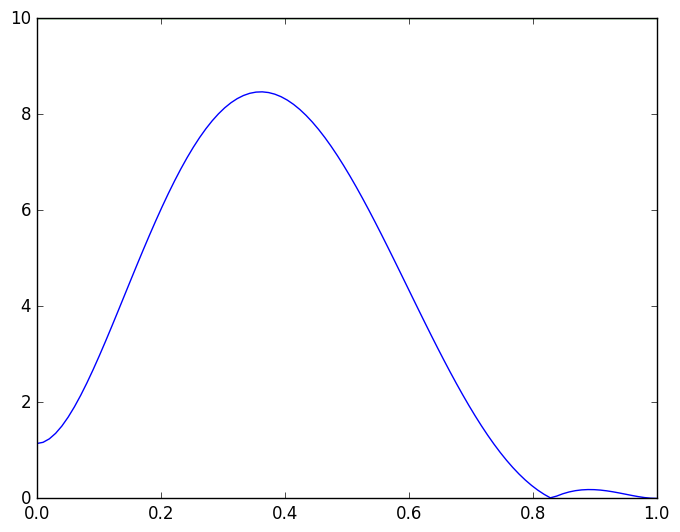

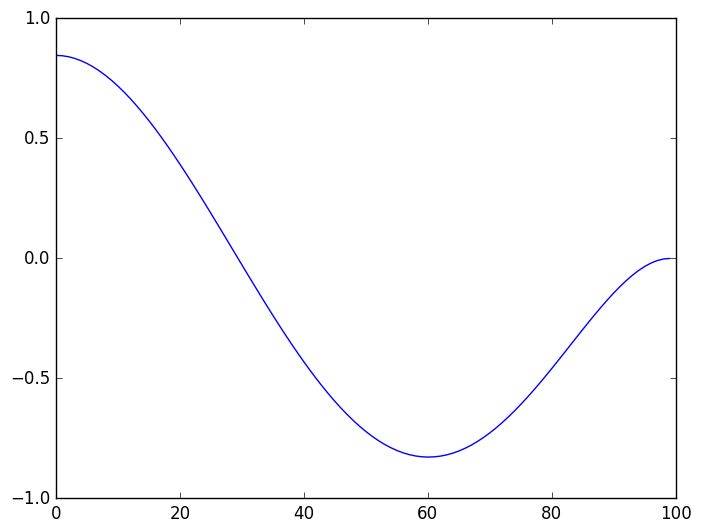

[10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0; 10.0]


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006CEC2D30>

In [837]:
#create lines
println(timeV)
println(plotTimes)
num = 1;
limit = ones(size(plotTimes,1), size(plotTimes,2)) * max_vel*(timeV-2)^num;
plot(plotTimes, sqrt((evaluate_poly(y_coeffs,num,plotTimes)).^2+(evaluate_poly(y_coeffs,num,plotTimes)).^2));
plot(plotTimes, limit)
println(limit)
figure()
plot(evaluate_poly(x_coeffs,1,plotTimes))

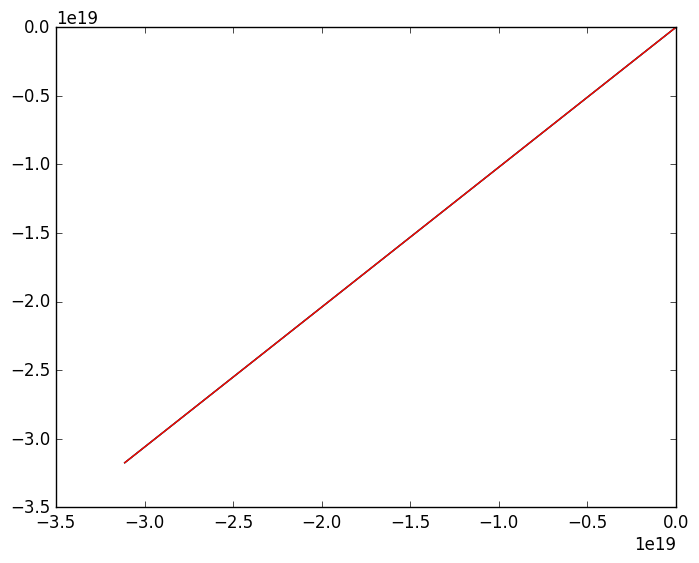

[3.44908,0.259226,0.0,2.79099,0.0,0.0]


In [757]:
for q = -1:1
    xcoeffs = Au*[10.2;1;0;20;0;0;187];
    ycoeffs = Au*[12.3;1.0;0;22.3;0;0;230+q];
    plotTimes = linspace(0,1,100);
    plot(evaluate_poly(xcoeffs,0,plotTimes),evaluate_poly(ycoeffs,0,plotTimes) );
end
println(y_constr)
#[10.2,1.0,0.0,20.0,9.8,-11.7333]
#[10.3,1.0,0.0,22.3,12.0,-14.6667]

In [85]:
println(x_coeffs)

[1.0,1.0,-2.03931e-16,-0.0107305,0.000172624,-6.6314e-7]


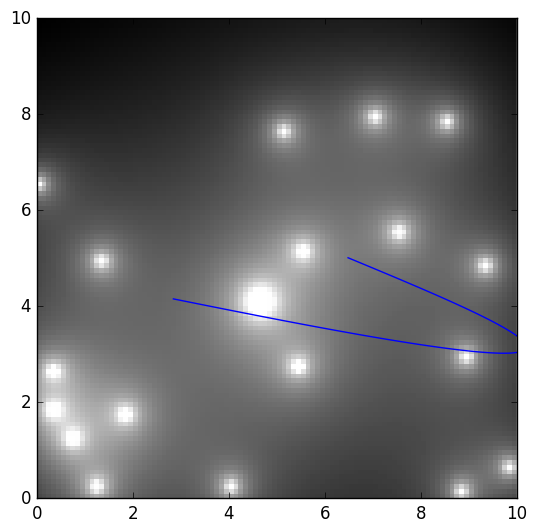

[157.843,156.525,155.725,154.733,154.116,153.838,151.959,151.762,149.454,149.058,148.597,146.555,145.966,145.324,143.067,142.485,141.949,140.827,140.478,140.235,139.448,139.396,139.468,139.096,139.367,139.214,139.405,139.488,139.179,138.883,138.286,138.311,137.147,135.601,135.965,133.808,131.381,128.946,126.3,123.16,120.134,120.21,117.19,137.366,144.238,149.551,156.2,151.744,117.128,120.579,124.497,129.058,134.536,141.375,150.332,162.777,181.231,208.941,231.674,210.631,173.101,162.67,154.703,148.843,144.534,141.344,138.976,137.228,137.358,136.249,135.482,135.004,134.778,134.775,134.978,135.372,136.011,136.614,137.392,138.346,139.481,140.807,142.972,144.678,146.597,148.743,151.13,153.767,156.801,159.769,162.938,166.275,169.737,173.261,177.048,181.061,185.376,190.092,195.296,208.119,217.425,227.162,235.119,237.731,255.0,242.589,223.718,207.986,195.416,188.047,179.053,171.905,166.119,161.37,161.446,157.394,154.024,151.209,148.857,146.899,146.494,144.871,143.554,142.511,141.718,140.761,140

In [772]:
    plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
    imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])

println(costmap[cells])